# 管井高度变化值统计分析工具

本工具用于**从 JSON 数据中提取管井高度信息（fidToSubAltitude）并进行统计分析和可视化**。

## 主要功能

1. 自动识别 JSON 文件编码（支持 UTF-8、UTF-16 等）
2. 修复 JSON 格式错误（如数组格式不规范）
3. 提取 fidToSubAltitude 数据并标准化
4. 统计分析（均值、标准差、分位数等）
5. 可视化展示（直方图、箱线图）
6. 导出统计结果和明细数据

## 应用场景

- 管井高程数据质量检查
- 管网高程变化分析
- 异常值识别
- 数据统计报告生成

> **依赖库**  
> - Pandas
> - NumPy
> - Matplotlib
> - Chardet（编码识别）
> 
> 安装命令：  
> ```bash
> pip install pandas numpy matplotlib chardet
> ```

In [1]:
# pip install pandas matplotlib
import re
import json
import chardet
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======== 配置路径 ========
JSON_PATH = r"F:\beipai\管井\Pre_well_mod.json"  # 你的 json 文件路径
OUTPUT_DIR = r"F:\beipai\管井\out"              # 输出目录
KEY_NAME = "fidToSubAltitude"



## 1. 配置参数

In [4]:
# pip install chardet
import chardet
import json

# 自动识别编码并读取
with open(JSON_PATH, "rb") as f:
    raw = f.read()
    enc = chardet.detect(raw)['encoding']
    data = json.loads(raw.decode(enc))

print(f"[DONE] JSON 成功读取，检测编码: {enc}")

[DONE] JSON 成功读取，检测编码: UTF-16


## 2. 自动识别编码并读取 JSON

In [5]:
# ========= 仅修复 fidToSubAltitude 段落中的 “key: num1, num2” =========
# 思路：
# 1) 找到 "fidToSubAltitude": 后面的对象 {...} 子串（用括号计数匹配）
# 2) 只在子串内把 `"KEY": num1, num2` 替换为 `"KEY": [num1, num2]`
def extract_object_substr(s: str, key: str):
    # 定位键名
    m = re.search(rf'"{re.escape(key)}"\s*:\s*{{', s)
    if not m:
        return None, None, None
    start = m.end() - 1  # 指向 '{'
    # 用栈匹配到对应的结束 '}' 位置
    depth = 0
    i = start
    while i < len(s):
        if s[i] == '{':
            depth += 1
        elif s[i] == '}':
            depth -= 1
            if depth == 0:
                end = i  # 包含右大括号
                return m.start(), start, end
        i += 1
    return None, None, None

head_idx, obj_start, obj_end = extract_object_substr(text, KEY_NAME)

if head_idx is None:
    raise KeyError(f"JSON 中未找到键 '{KEY_NAME}' 的对象段落。")

prefix = text[:obj_start]
obj_body = text[obj_start:obj_end+1]  # 包含首尾花括号
suffix = text[obj_end+1:]

# 在 obj_body 内用正则把 "key": num1, num2 变为 "key": [num1, num2]
# 数值支持整数/小数/科学计数法；确保只匹配 “冒号后的两个数值” 形式
num_pattern = r'-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?'
pair_value_pattern = rf'("([^"\\]|\\.)*")\s*:\s*({num_pattern})\s*,\s*({num_pattern})(\s*[,\n\r]|\s*}}|\s*])'

def replacer(m):
    key_quoted = m.group(1)
    v1 = m.group(3)
    v2 = m.group(4)
    tail = m.group(5)
    return f'{key_quoted}: [{v1}, {v2}]{tail}'

fixed_obj_body = re.sub(pair_value_pattern, replacer, obj_body)

fixed_text = prefix + fixed_obj_body + suffix

NameError: name 'text' is not defined

## 3. 修复 JSON 格式

处理 `"key": num1, num2` 格式错误，转换为 `"key": [num1, num2]`。

**注意**：此 cell 可能因缺少 `text` 变量而报错，可跳过或修复。

In [6]:
# ========= 提取并标准化为 (fid, value) =========
arr = data.get(KEY_NAME)
if arr is None:
    raise KeyError(f"修复后 JSON 中仍未找到 '{KEY_NAME}' 键。")

# 支持两种常见结构：
# 1) dict: { "G074956": 12.3, "G074957": [11.1, 11.3], ... }
# 2) list: [12.3, 11.1, ...]  或  [{"fid":"xx", "value":12.3}, ...]
records = []

if isinstance(arr, dict):
    for k, v in arr.items():
        if isinstance(v, (int, float)):
            val = float(v)
        elif isinstance(v, list) and all(isinstance(x, (int, float)) for x in v) and len(v) > 0:
            val = float(np.mean(v))  # 列表取平均；若想取第一个改为 float(v[0])
        else:
            # 尝试从字符串中提取数值（兜底）
            if isinstance(v, str):
                nums = re.findall(num_pattern, v)
                if nums:
                    val = float(nums[0])
                else:
                    continue
            else:
                continue
        records.append({"fid": k, "value": val})

elif isinstance(arr, list):
    # 如果是纯数值列表
    if all(isinstance(x, (int, float)) for x in arr):
        for i, v in enumerate(arr):
            records.append({"fid": str(i), "value": float(v)})
    # 如果是对象列表，尝试识别 value 字段
    elif all(isinstance(x, dict) for x in arr):
        # 找一个数值字段名
        candidates = [k for k, v in arr[0].items() if isinstance(v, (int, float))]
        if not candidates:
            raise ValueError(f"无法从 {KEY_NAME} 的对象元素中识别数值字段。")
        val_key = candidates[0]
        fid_key = "fid" if "fid" in arr[0] else None
        for i, item in enumerate(arr):
            if isinstance(item.get(val_key), (int, float)):
                val = float(item[val_key])
                fid = str(item.get(fid_key)) if fid_key else str(i)
                records.append({"fid": fid, "value": val})
else:
    raise TypeError(f"{KEY_NAME} 的数据类型暂不支持：{type(arr)}")

if not records:
    raise ValueError(f"{KEY_NAME} 解析后为空。")

df = pd.DataFrame(records)





## 4. 提取并标准化数据

支持 dict 和 list 两种数据结构，处理单值和数组值。

In [7]:
df

,fid,value
0,G000083,-4.885880
1,G000085,-4.500271
2,G000086,-2.640827
3,G000087,-1.798569
4,G000088,-2.692509
...,...,...
179141,B023351,2.290003
179142,B023317,4.280003
179143,B023318,3.538879
179144,B023331,0.185812


In [8]:
# ======== 统计结果 ========
# ========= 统计与导出 =========
summary = df["value"].describe(percentiles=[0.25, 0.5, 0.75]).to_frame().T.rename(columns={
    "count": "样本数", "mean": "平均值", "std": "标准差", "min": "最小值",
    "25%": "下四分位数", "50%": "中位数", "75%": "上四分位数", "max": "最大值"
})

print("=== fidToSubAltitude 统计结果 ===")
print(summary)

=== fidToSubAltitude 统计结果 ===
            样本数       平均值       标准差        最小值     下四分位数       中位数     上四分位数  \
value  179146.0 -3.627846  1.754339 -47.453106 -4.600109 -3.355911 -2.503975   

             最大值  
value  15.088856  


## 5. 统计分析

计算描述性统计量（均值、标准差、分位数等）。

In [9]:
summary_csv = Path(OUTPUT_DIR) / f"{KEY_NAME}_summary.csv"
detail_csv  = Path(OUTPUT_DIR) / f"{KEY_NAME}_detail.csv"
summary.to_csv(summary_csv, index=False, encoding="utf-8-sig")
df.to_csv(detail_csv, index=False, encoding="utf-8-sig")

print(f"[DONE] 统计表已保存：{summary_csv}")
print(f"[DONE] 明细表已保存：{detail_csv}")

[DONE] 统计表已保存：F:\beipai\管井\out\fidToSubAltitude_summary.csv
[DONE] 明细表已保存：F:\beipai\管井\out\fidToSubAltitude_detail.csv


## 6. 导出结果

保存统计表和明细表为 CSV 文件。

C:\Users\lishuhao\AppData\Local\Temp\ipykernel_34256\599614787.py:8: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lishuhao\AppData\Local\Temp\ipykernel_34256\599614787.py:8: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lishuhao\AppData\Local\Temp\ipykernel_34256\599614787.py:8: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lishuhao\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lishuhao\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


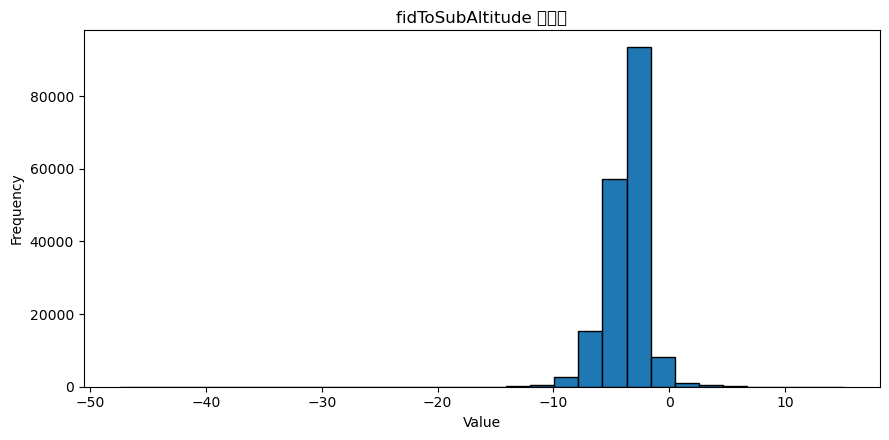

C:\Users\lishuhao\AppData\Local\Temp\ipykernel_34256\599614787.py:16: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lishuhao\AppData\Local\Temp\ipykernel_34256\599614787.py:16: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lishuhao\AppData\Local\Temp\ipykernel_34256\599614787.py:16: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lishuhao\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lishuhao\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

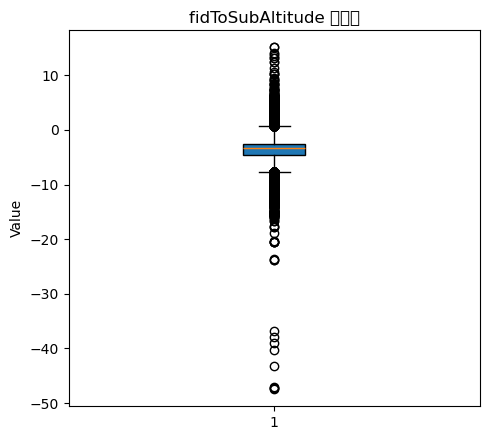

In [11]:
# ========= 可视化（可选）=========
plt.figure(figsize=(9,4.5))
# 直方图
plt.hist(df["value"], bins=30, edgecolor="black")
plt.title(f"{KEY_NAME} 直方图")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4.5))
# 箱线图
plt.boxplot(df["value"], vert=True, patch_artist=True)
plt.title(f"{KEY_NAME} 箱线图")
plt.ylabel("Value")
plt.tight_layout()
plt.show()



## 7. 数据可视化

绘制直方图和箱线图，直观展示数据分布。